In [1]:
import mne
from mne.io import read_raw_edf

import numpy as np


In [32]:

raw = read_raw_edf("", montage='easycap-M1', stim_channel=None, preload=True) #пропишите путь до файла в формате .edf
raw.info


Extracting EDF parameters from /home/mikhail/ML/test1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...   603.998 secs...


<ipython-input-32-17aefe65fb03>:1: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['AUX1 (HEARTBEAT)']
  raw = read_raw_edf("test1.edf", montage='easycap-M1', stim_channel=None, preload=True)
<ipython-input-32-17aefe65fb03>:1: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['AUX1 (HEARTBEAT', 'AUX2 (GSR)']. Their position has been left untouched.
  raw = read_raw_edf("test1.edf", montage='easycap-M1', stim_channel=None, preload=True)


<Info | 17 non-empty fields
    bads : list | 0 items
    ch_names : list | Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, ...
    chs : list | 65 items (EEG: 65)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : list | 63 items (63 EEG)
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 250.0 Hz
    meas_date : tuple | 2018-07-09 09:14:06 GMT
    nchan : int | 65
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 500.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xplot

In [41]:

raw.drop_channels([raw.ch_names[63], raw.ch_names[64]]) # AUX(heartbeat) deletion


IndexError: list index out of range

In [34]:

raw.info['bads'] = ['O1', 'C3']
raw.interpolate_bads(reset_bads=True, mode="accurate")
raw.set_eeg_reference('average', projection=False)


Computing interpolation matrix from 61 sensor positions
Interpolating 2 sensors
Applying average reference.
Applying a custom EEG reference.


<RawEDF  |  test1.edf, n_channels x n_times : 63 x 302000 (604.0 sec), ~145.3 MB, data loaded>

Using matplotlib backend: TkAgg
Using channel Fp2 as EOG channel
EOG channel index for this subject is: [31]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 2 - 45 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 2.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 1.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 45.25 Hz)
- Filter length: 8192 samples (16.384 sec)

Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequen

<ipython-input-42-8116df772de1>:8: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot)


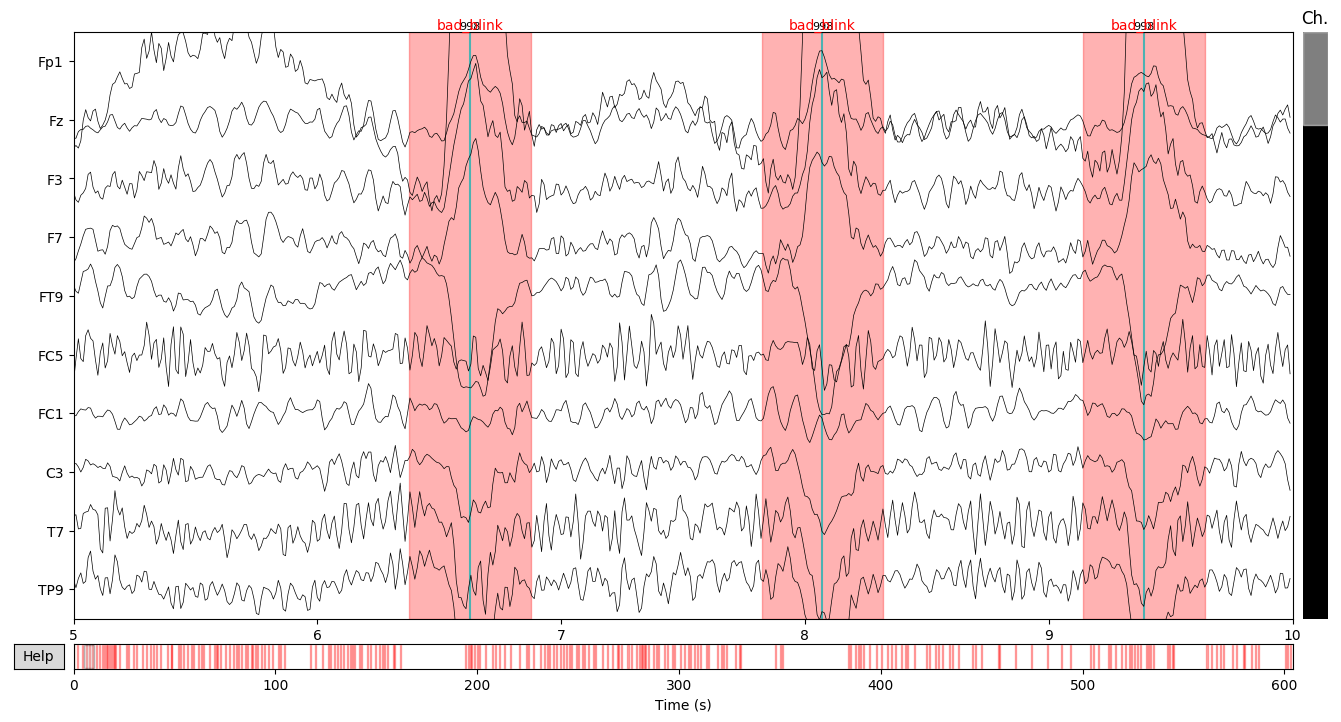

In [42]:

%matplotlib auto

eog_events = mne.preprocessing.find_eog_events(raw, ch_name="Fp2") # 
n_blinks = len(eog_events)
onset = eog_events[:,0] / raw.info['sfreq'] - 0.25
duration = np.repeat(0.5, n_blinks)
annot = mne.Annotations(onset, duration, ['bad_blink'] * n_blinks, orig_time=raw.info['meas_date'])
raw.set_annotations(annot)
print(raw.annotations)
raw.plot(events=eog_events, duration=5.0, start=5.0, n_channels=10)



In [43]:

from mne.preprocessing import ICA, create_eog_epochs

method = "fastica"
n_components = 30
decim = 3 # 3 epochs
reject = dict(eeg=40e-6) # delete peak amplitudes

raw.filter(1., 30., fir_design='firwin')  # 1-30 Hz
ica = ICA(n_components, method=method, random_state=23)
ica.fit(raw, decim=decim)

print(ica)
ica.plot_components()


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (3.302 sec)

Fitting ICA to data using 63 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Omitting 58538 of 302000 (19.38%) samples, retaining 243462 (80.62%) samples.
Selection by number: 30 components
Fitting ICA took 8.7s.
<ICA  |  raw data decomposition, fit (fastica): 81154 samples, 30 components, channels used: "eeg">


[<Figure size 750x683 with 20 Axes>, <Figure size 750x400 with 10 Axes>]

In [44]:
eog_average = create_eog_epochs(raw, ch_name = 'Fp2', reject_by_annotation = False).average()

eog_epochs = create_eog_epochs(raw, ch_name = "Fp2", reject_by_annotation = False)

eog_inds, scores = ica.find_bads_eog(eog_epochs, ch_name = "Fp2", threshold = 2.0, l_freq = 1, h_freq = 10, reject_by_annotation = True)

Using channel Fp2 as EOG channel
EOG channel index for this subject is: [31]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 2 - 45 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 2.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 1.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 45.25 Hz)
- Filter length: 8192 samples (16.384 sec)

Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband ed

    Using multitaper spectrum estimation with 7 DPSS windows
Transforming to ICA space (30 components)
Zeroing out 3 ICA components
Transforming to ICA space (30 components)
Zeroing out 3 ICA components


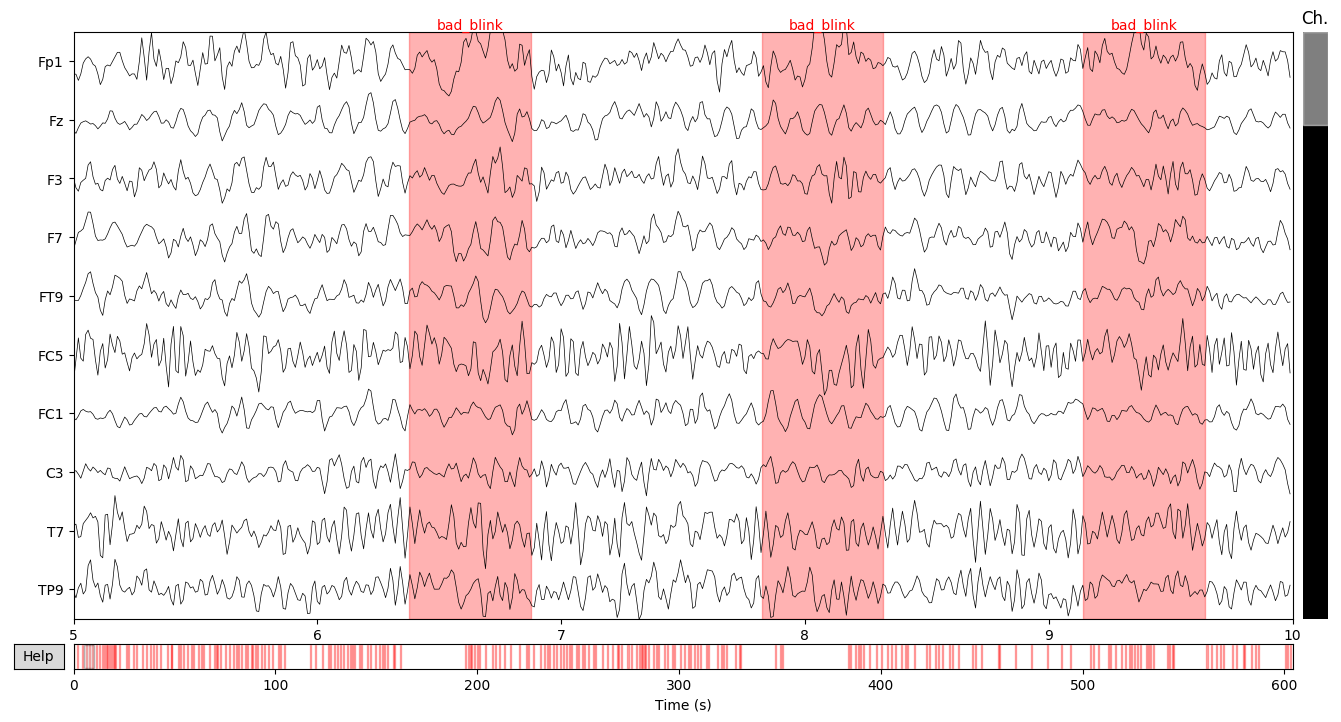

In [45]:
ica.plot_scores(scores, exclude = eog_inds)
ica.plot_sources(eog_average, exclude = eog_inds)

ica.plot_properties(eog_epochs, picks = eog_inds, psd_args = {'fmax': 30.}, image_args = {'sigma':1.})
ica.plot_overlay(eog_average, exclude = eog_inds, show = True)

ica.apply(raw, include = None, exclude = eog_inds, n_pca_components = None)
raw.plot(duration = 5.0, start = 5.0, n_channels = 10)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)

Setting 58538 of 302000 (19.38%) samples to NaN, retaining 243462 (80.62%) samples.
Effective window size : 4.096 (s)
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 133 samples (0.266 sec)

Setting 58538 of 302000 (19.38%) samples to NaN, re

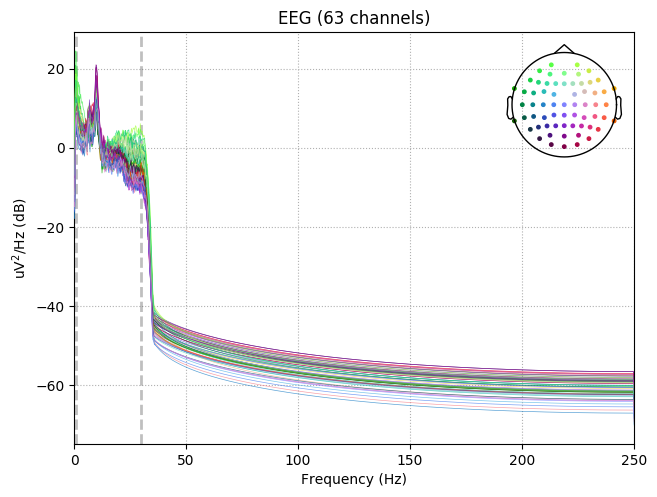

In [46]:
raw.notch_filter(np.arange(50, 241, 50), filter_length = 'auto', phase = 'zero')
raw.plot_psd(area_mode = 'range', average = False)

raw.filter(None, 50., fir_design = 'firwin')
raw.plot_psd(area_mode = 'range', average = False)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting 58538 of 302000 (19.38%) samples to NaN, retaining 243462 (80.62%) samples.
Effective window size : 4.096 (s)
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband

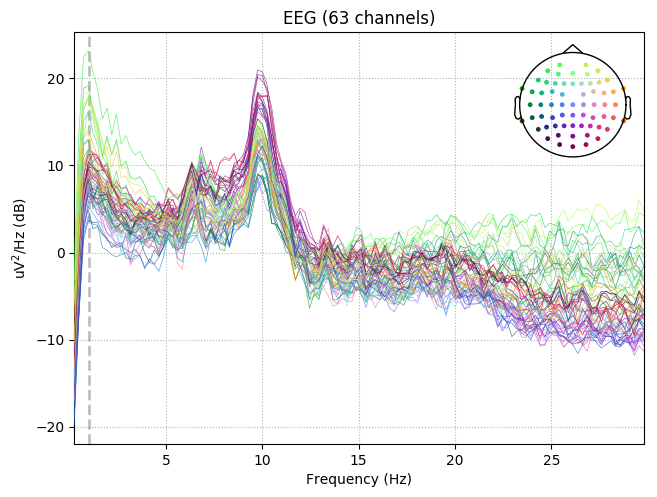

In [47]:
raw.filter(1, None, fir_design = 'firwin')
raw.plot_psd(area_mode = 'range', average = False)

raw.filter(1, 30, fir_design = 'firwin')
raw.plot(duration = 5.0, start = 5.0, n_channels = 10, butterfly = False)
raw.plot_psd(fmin = 0.1, fmax = 30, area_mode = None, average = False)

In [25]:
print(raw.info)
print(raw.ch_names)

<Info | 17 non-empty fields
    bads : list | 0 items
    ch_names : list | Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, ...
    chs : list | 63 items (EEG: 63)
    comps : list | 0 items
    custom_ref_applied : bool | True
    dev_head_t : Transform | 3 items
    dig : list | 63 items (63 EEG)
    events : list | 0 items
    highpass : float | 1.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 30.0 Hz
    meas_date : tuple | 2018-07-09 09:14:06 GMT
    nchan : int | 63
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 500.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xplotte